In [1]:
%matplotlib inline

import re
import numpy
import json
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import random

In [165]:
#main_folder = "/Users/ofek/PCA_CF/compareToDva"
#model_file = "modelFile_main_201811060700.json"
main_folder = "/Users/ofek/PCA_CF/evaluate"
model_file = "modelFile_main_201904100615_00488_4281358-190306200501074-oozie-PR-C_lfmModel10.json"
model_file_path = main_folder + "/" + model_file
model_low_file_path = main_folder + "modelFile_main_201811060700_low.json"
# choose the number of values per ad in the new model
orig_dim = 890
K = 550

tmp_pca_matrix_file_path = main_folder + "tmp_pca_matrix.tmp"
tmp_low_matrix_file_path = main_folder + "tmp_low_matrix.tmp"

ad_vec_pattern = re.compile(r".*\"creative_id\.([0-9]*)\":\[(.*)\].*")  # for ad vectors count
ad_vec_sub_pattern = re.compile(r"(.*\"creative_id\.[0-9]*\":\[).*(\].*)")  # for vector substitution

In [166]:
# *******
# methods
# =======

def get_user_features(model_file_path):
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return json.loads(''.join(ret))
            else:
                if ok_to_write:
                    line_list.append(line)
    return None


def getUserFeaturesVector(label_vectors, row_idx, user_features):
    labels_count = 0
    for feature_name in user_features:
        label_count = 0
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it, it will be added later
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue
        for label in feature:
            label_vectors[row_idx] = numpy.array(feature[label]);
            row_idx += 1
            label_count += 1
        print("Done for feature_name [" + feature_name + "] label_count [" + str(label_count) + "]")
        labels_count += label_count
    return labels_count


# for features that are added together before multiplication
def getListUserFeatureVector(label_vectors, row_idx, user_features, feature_name, sub_feature_name = None):
    labels_count = 0
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # get NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    neutral_label_vec = numpy.array(neutral_label_map[neutral_label])
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    for label in list_feature:
        list_feature_vector = numpy.array(list_feature[label])
        list_feature_vector = numpy.add(list_feature_vector, neutral_label_vec)
        label_vectors[row_idx] = list_feature_vector
        row_idx += 1
        labels_count += 1

    print("Done for feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels_count [" + str(labels_count) + "]")
    return labels_count


def generate_label_vectors_matrix(model_file_path):
    user_features = get_user_features(model_file_path)
    max_num_of_rows = numpy.sum([len(user_features[feature]) for feature in user_features])
    print("max_num_of_rows [" + str(max_num_of_rows) + "]")
    # count how many NEUTRAL vectors there are
    num_of_neutral_vectors = 0
    for feature_name in user_features:
        feature = user_features[feature_name]
        num_of_neutral_vectors += len([p for p in feature.keys() if "NEUTRAL" in p])
    label_vectors_matrix = numpy.zeros(shape=(max_num_of_rows - num_of_neutral_vectors, orig_dim))

    row_idx = 0
    row_idx += getUserFeaturesVector(label_vectors_matrix, row_idx, user_features)
    #row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp5_allMappi")
    #row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp1_userCategory")
    
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp6_ctrCategoryPS")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp2_userClickedCategory")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp9_allMappiPS")
    
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yic_mv")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yct_c_mv_w")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "userSignal")

    return label_vectors_matrix


# Algorithm

In [160]:
# get number of ads in the model
num_of_ads = 0
with open(model_file_path, 'r') as model_file:
    for line in model_file:
        if ad_vec_pattern.match(line):
            num_of_ads += 1

print("ad num [" + str(num_of_ads) + "]")

# prepare the matrix with all the ad vectors in rows
X = numpy.zeros(shape=(num_of_ads, orig_dim))
creative_ids = []
with open(model_file_path, 'r') as model_file:
    ad_idx = 0
    for line in model_file:
        m = ad_vec_pattern.match(line)
        if m:
            creative_id = m.group(1)
            creative_ids.append(creative_id)
            X[ad_idx] = numpy.fromstring(m.group(2), sep=",")
            ad_idx += 1

assert ad_idx == num_of_ads
#assert numpy.sum(X[:,(orig_dim - 2)]) == 0  # all values in col are 0
assert numpy.sum(X[:,(orig_dim - 1)]) == X.shape[0]  # all values in col are 1

# generate the label vectors
label_vectors_matrix = generate_label_vectors_matrix(model_file_path)

# the last col is the label vector bias and is equal in all label vectors
# argmax - returns the index of the maximum value along the axis
# the bias is taken from one of the "day" user feature vector (any of them)
user_vector_bias = label_vectors_matrix[(label_vectors_matrix[:, (orig_dim - 1)] != 1.0).argmax(axis=0), (orig_dim - 1)]

# all values in col are user_vector_bias
# 8 amounts to the number of "day" feature labels - (1-7) + 1 UNKNOWN label. located here label_vectors_matrix[15460:15470,:]
# Haifa choose to add the bias in the "day" feature. Since it is only in one feature, any user vector that is generated will have
# the bias in the last value of the vector.
#assert numpy.sum(label_vectors_matrix[:,(orig_dim - 1)] != 1.0) == 8

# calculate PCA
# 1) append the matrices
X_for_pca = numpy.concatenate((X, label_vectors_matrix), axis=0)

assert X_for_pca.shape[1] == orig_dim

# 2) remove the last two cols which contain 0 and 1 for bias
X_for_pca = numpy.delete(X_for_pca, (orig_dim - 1), 1)  # all ones
#X_for_pca = numpy.delete(X_for_pca, (orig_dim - 2), 1)  # all zeros

# 3) calculate the covariance matrix Sigma
Sigma = numpy.matmul(numpy.transpose(X_for_pca), X_for_pca) / X_for_pca.shape[0]  # (1/|rows in X|) * (X' * X)
# sigma_mean = numpy.mean(Sigma, axis = 0)
# Sigma_mean = Sigma - sigma_mean
# sigma_std = numpy.std(Sigma_mean, axis = 0)
# Sigma_normal = Sigma_mean / sigma_std
UX, SX, _ = numpy.linalg.svd(Sigma)  # [U S V] = svd(Sigma);

# use PCA UX matrix to reduce the dimension of the ad vectors
# calculate preserved variance percentage for declaration in the model file
preserved_variance_pct = (numpy.sum(SX[0:K]) * 100.0) / numpy.sum(SX)
# reduce the dimension of the ad vectors
#X_low = numpy.matmul(X[:, 0:(orig_dim - 2)], UX[:, 0:K])  # Z = X * U(:, 1:K);
X_low = numpy.matmul(X[:, 0:(orig_dim - 1)], UX[:, 0:K])  # Z = X * U(:, 1:K);

assert X_low.shape[1] == K
assert X_low.shape[0] == X.shape[0]

# add a ones col for user vector bias addition
X_low = numpy.concatenate((X_low, numpy.ones((X_low.shape[0], 1))), axis=1)

assert X_low.shape[1] == (K + 1)
assert X_low.shape[0] == X.shape[0]
assert X_low.shape[0] == num_of_ads

print("Done")


ad num [214371]
max_num_of_rows [30588]
Done for feature_name [local_hour] label_count [25]
Done for feature_name [sectionId] label_count [14432]
Done for feature_name [state] label_count [3437]
Done for feature_name [user_involvement] label_count [10]
Done for feature_name [age] label_count [126]
Done for feature_name [gender] label_count [4]
Done for feature_name [externalFeature] sub_feature_name [exp6_ctrCategoryPS] labels_count [253]
Done for feature_name [externalFeature] sub_feature_name [exp2_userClickedCategory] labels_count [20]
Done for feature_name [externalFeature] sub_feature_name [exp9_allMappiPS] labels_count [2862]
Done for feature_name [yic_mv] sub_feature_name [None] labels_count [96]
Done for feature_name [yct_c_mv_w] sub_feature_name [None] labels_count [1041]
Done for feature_name [userSignal] sub_feature_name [None] labels_count [8276]
Done


In [171]:
print(label_vectors_matrix[0:10,:889])

[[ 1.         1.         1.        ... -0.5870662  1.         1.       ]
 [ 1.         1.         1.        ... -0.4036418  1.         1.       ]
 [ 1.         1.         1.        ...  0.2294401  1.         1.       ]
 ...
 [ 1.         1.         1.        ...  0.2650838  1.         1.       ]
 [ 1.         1.         1.        ...  0.2251617  1.         1.       ]
 [ 1.         1.         1.        ...  0.1083642  1.         1.       ]]


# Plot the variance preservance

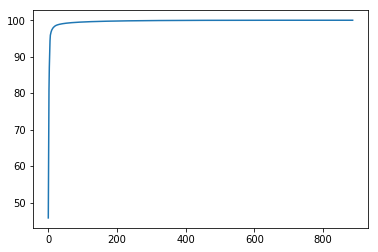

In [161]:
sx_all = numpy.sum(SX)
df_map = {
    'k': range(1, (orig_dim - 2)),
    'variance': [((numpy.sum(SX[0:k]) * 100.0) / sx_all) for k in range(1, (orig_dim - 2))]
}
sx_df = pd.DataFrame.from_dict(df_map)
#print(sx_df)
#sx_df.plot(x='k', y='variance', style='o')
plt.plot(sx_df['variance'])

# Write the new model to a json file

In [8]:
# copy all the lines in the file
open(model_low_file_path, 'w').close()  # delete output file content
open(tmp_pca_matrix_file_path, 'w').close()  # delete the content of the tmp pca matrix file
open(tmp_low_matrix_file_path, 'w').close()  # delete the content of the tmp X_low matrix file
start_time_sec = int(time.time())
with open(model_file_path, 'r') as model_file, open(model_low_file_path, 'a') as model_low_file:
    # pca data is inserted before the feature vectors section starts
    while True:
        line = model_file.readline()
        if "\"user\":{\n" in line:
            break
        model_low_file.write(line)
    model_low_file.write("\"pca\":{\n")
    model_low_file.write("\"usedVecDim\": \"" + str(K) + "\",\n")
    model_low_file.write("\"preservedVariancePct\": \"" + str(preserved_variance_pct) + "\",\n")
    model_low_file.write("\"userVectorBias\": \"" + str(user_vector_bias) + "\",\n")
    model_low_file.write("\"UX\": \n")
    with open(tmp_pca_matrix_file_path, 'w') as tmp_pca_matrix_file:
        numpy.savetxt(tmp_pca_matrix_file, UX, delimiter=",", fmt="%1.6E")
    model_low_file.write("[\n")
    with open(tmp_pca_matrix_file_path, 'r') as tmp_pca_matrix_file:
        count = 0
        for pca_matrix_row in tmp_pca_matrix_file:
            count += 1
            model_low_file.write("[" + pca_matrix_row.strip().replace("E-0", "E-").replace("E+0", "E+") + "]" + (",\n" if count < (orig_dim - 2) else "\n"))
    # delete the tmp file
    open(tmp_pca_matrix_file_path, 'w').close()
    model_low_file.write("]\n")
    model_low_file.write("},\n")  # close for pca section

    # feature vectors remain as they are (original dimension of `orig_dim`)
    model_low_file.write("\"user\":{\n")
    while True:
        line = model_file.readline()
        model_low_file.write(line)
        if "\"ad\":" in line:
            break

    # write all the new lower dimension creatives' vectors
    # in bash: `cat lfmModel12_201809010945.json.gz | gzip -cd | grep "\"creative_id\.[0-9]*\":\[" | sed -E -e "s/.*\"creative_id\.([0-9]*)\":\[(.*)\].*/\1 \2/g" | tr ',' ' ' > lfmModel12_201809010945.m`

    with open(tmp_low_matrix_file_path, 'w') as tmp_low_matrix_file:
        numpy.savetxt(tmp_low_matrix_file, X_low, delimiter=",", fmt="%1.6E")
    with open(tmp_low_matrix_file_path, 'r') as tmp_low_matrix_file:
        ad_idx = 0
        while True:
            line = model_file.readline()
            if not line:
                assert not tmp_low_matrix_file.readline()
                break
            m = ad_vec_sub_pattern.match(line)
            if m:
                X_low_row = tmp_low_matrix_file.readline()
                X_low_row = X_low_row.replace('\n', '').replace(' ', '').replace("E-0", "E-").replace("E+0", "E+")
                new_ad_vector_line = m.group(1) + X_low_row + m.group(2) + "\n"
                # TODO: sanity, make sure the line is correct using the `ad_vec_pattern` regex
                ms = ad_vec_pattern.match(new_ad_vector_line)
                if ms:
                    ad_idx += 1
                    model_low_file.write(new_ad_vector_line)
                else:
                    print "ERROR with line [" + new_ad_vector_line + "]"
            else:
                model_low_file.write(line)

    # delete the tmp file
    open(tmp_low_matrix_file_path, 'w').close()

print("Done in [" + str(int(time.time()) - start_time_sec) + "] sec")
print("Number of written ads/number of ads in original model [" + str(ad_idx) + "/" + str(num_of_ads) + "]")


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("ERROR with line [" + new_ad_vector_line + "]")? (<ipython-input-8-fdde7d339e59>, line 65)

# Generate random user profile vectors

In [133]:
num_of_profiles_to_generate = 500

def get_user_features_string():
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return ''.join(ret)
            else:
                if ok_to_write:
                    line_list.append(line)


def coin_toss(p=.5):
    return True if random.random() < p else False


def get_user_features_vector(user_features):
    feature_vector = numpy.ones(orig_dim)
    for feature_name in user_features:
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue;
        rand_index = random.randint(0, len(feature.keys()) - 1)
        chosen_label = list(feature)[rand_index]
        #print("feature_name [" + feature_name + "] label [" + chosen_label + "]")
        feature_vector = numpy.multiply(feature_vector, feature[chosen_label])

    #print numpy.array2string(feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return feature_vector


# for features that are added together before multiplication
def get_list_user_feature_vector(user_features, feature_name, sub_feature_name = None, maxNumOfLabels = 100):
    considered_labels = []
    list_feature_vector = numpy.zeros(orig_dim)
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # add NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    considered_labels.append(neutral_label)
    list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[neutral_label]))
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    # choose UNKNOWN
    if coin_toss(0.05):
        # in this case only UNKNOWN (and NEUTRAL) should be picked
        unknown_label_map = { k: v for k, v in list_feature.items() if "UNKNOWN" in k }
        unknown_label = list(unknown_label_map.keys())[0]
        considered_labels.append(unknown_label)
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[unknown_label]))
        #print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
        #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
        return list_feature_vector

    # remove UNKNOWN label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "UNKNOWN" not in k }

    # choose max maxNumOfLabels labels from list_feature
    labels = random.sample(list(list_feature), random.randint(1, min(len(list_feature), maxNumOfLabels)))
    considered_labels.append(labels)
    vector_values = [list_feature[label] for label in labels]

    for vector_value in vector_values:
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(vector_value))

    #print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
    #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return list_feature_vector


def generateUserVector(user_features):
    user_vector = numpy.ones(orig_dim)

    user_vector = numpy.multiply(user_vector, get_user_features_vector(user_features))
    #user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "externalFeature", "exp5_allMappi"))
    #user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "externalFeature", "exp1_userCategory"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "externalFeature", "exp9_allMappiPS"))
    
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "yic_mv"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "yct_c_mv_w"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "userSignal"))

    return user_vector

user_features = json.loads(get_user_features_string())
user_vectors_mat = numpy.empty((0,orig_dim), int)
for i in range(num_of_profiles_to_generate):
    print("Generating user vector [" + str(i) + "]")
    user_vector = generateUserVector(user_features)
    user_vectors_mat = numpy.append(user_vectors_mat, [user_vector], axis=0)

print("")
print(user_vectors_mat)

print("")
print("user_vectors_mat dim [" + str(user_vectors_mat.shape[0]) + "X" + str(user_vectors_mat.shape[1]) + "]")

# user_vectors_df = pd.DataFrame({'Column1':data[:,0],'Column2':data[:,1]})
# print(user_vectors_df)


Generating user vector [0]
Generating user vector [1]
Generating user vector [2]
Generating user vector [3]
Generating user vector [4]
Generating user vector [5]
Generating user vector [6]
Generating user vector [7]
Generating user vector [8]
Generating user vector [9]
Generating user vector [10]
Generating user vector [11]
Generating user vector [12]
Generating user vector [13]
Generating user vector [14]
Generating user vector [15]
Generating user vector [16]
Generating user vector [17]
Generating user vector [18]
Generating user vector [19]
Generating user vector [20]
Generating user vector [21]
Generating user vector [22]
Generating user vector [23]
Generating user vector [24]
Generating user vector [25]
Generating user vector [26]
Generating user vector [27]
Generating user vector [28]
Generating user vector [29]
Generating user vector [30]
Generating user vector [31]
Generating user vector [32]
Generating user vector [33]
Generating user vector [34]
Generating user vector [35]
Ge

Generating user vector [293]
Generating user vector [294]
Generating user vector [295]
Generating user vector [296]
Generating user vector [297]
Generating user vector [298]
Generating user vector [299]
Generating user vector [300]
Generating user vector [301]
Generating user vector [302]
Generating user vector [303]
Generating user vector [304]
Generating user vector [305]
Generating user vector [306]
Generating user vector [307]
Generating user vector [308]
Generating user vector [309]
Generating user vector [310]
Generating user vector [311]
Generating user vector [312]
Generating user vector [313]
Generating user vector [314]
Generating user vector [315]
Generating user vector [316]
Generating user vector [317]
Generating user vector [318]
Generating user vector [319]
Generating user vector [320]
Generating user vector [321]
Generating user vector [322]
Generating user vector [323]
Generating user vector [324]
Generating user vector [325]
Generating user vector [326]
Generating use

## write user vectors to .m file

In [15]:
user_vectors_file_path = "/Users/ofek/PCA_CF/compareToDva/modelFile_main_201811060700_user_vectors.m"

open(user_vectors_file_path, 'w').close()  # delete file content
with open(user_vectors_file_path, 'a') as user_vector_file:
    for user_vector in user_vectors_mat:
        user_vector = numpy.array2string(user_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
        user_vector = ' '.join(user_vector.split())
        user_vector = re.sub(r'^\[|\]$', '', user_vector)
        user_vector_file.write(user_vector + "\n")

# Evaluate the model

creatives_rank_real:
                  0          1          2         3          4          5    \
34326707096  0.838866  -4.143866  -9.732029 -4.084799  -2.833670  -8.564925   
34847249651  5.628879 -10.374620  -9.522117 -8.777521 -19.657603  -9.779763   
34592589330  5.549601  -6.768791  -9.957059 -6.228603  -8.673653  -9.659074   
34847249653  5.675341 -10.355758  -9.553896 -8.773062 -19.643514  -9.817136   
34592589331  7.345817  -6.380552 -11.294954 -5.229796  -8.140434 -10.727592   
34847249654  5.616789 -10.348019  -9.547419 -8.772983 -19.606600  -9.796668   
34847249656  6.135269 -10.118877  -9.913546 -8.442194 -19.877120 -10.117336   
34847249657  5.928088 -10.330088 -10.179583 -8.653990 -20.013553 -10.225827   
34470108298  4.352612  -6.559536  -9.635518 -5.209249  -7.695639  -8.428024   
34847249658  6.057371 -10.411749  -9.608529 -8.876193 -19.690480  -9.401500   
34116853071  2.404799  -6.056515 -13.108197 -4.427469  -5.487670 -10.612627   
34116853075  2.131846  -3.33511

creatives_rank_low:
                  0          1          2         3          4          5    \
34326707096  1.082605  -4.098927  -9.480277 -3.912342  -2.675032  -8.344470   
34847249651  5.695596 -10.370375  -9.463876 -8.745538 -19.642469  -9.730211   
34592589330  5.597340  -6.769263  -9.930923 -6.216462  -8.657672  -9.632656   
34847249653  5.743346 -10.352868  -9.493063 -8.739252 -19.632074  -9.764993   
34592589331  7.332696  -6.422094 -11.319700 -5.256891  -8.199784 -10.740621   
34847249654  5.680350 -10.347987  -9.491623 -8.744532 -19.598735  -9.749546   
34847249656  6.172419 -10.111090  -9.874605 -8.418342 -19.850451 -10.084588   
34847249657  5.965677 -10.326446 -10.139811 -8.632536 -19.988444 -10.192165   
34470108298  4.381184  -6.535241  -9.633818 -5.183560  -7.657231  -8.428535   
34847249658  6.055051 -10.420577  -9.614792 -8.882602 -19.698726  -9.402288   
34116853071  2.394713  -6.099462 -13.127260 -4.450398  -5.544514 -10.620279   
34116853075  2.243273  -3.384182

creatives_rank_diff:
                  0         1         2         3         4         5    \
34326707096  0.243739  0.044938  0.251752  0.172457  0.158638  0.220456   
34847249651  0.066717  0.004245  0.058240  0.031983  0.015134  0.049552   
34592589330  0.047738  0.000472  0.026136  0.012141  0.015981  0.026418   
34847249653  0.068005  0.002890  0.060833  0.033810  0.011440  0.052143   
34592589331  0.013121  0.041542  0.024746  0.027094  0.059350  0.013029   
34847249654  0.063561  0.000032  0.055796  0.028450  0.007865  0.047122   
34847249656  0.037150  0.007787  0.038941  0.023852  0.026669  0.032748   
34847249657  0.037590  0.003642  0.039773  0.021453  0.025109  0.033661   
34470108298  0.028572  0.024296  0.001700  0.025688  0.038408  0.000511   
34847249658  0.002319  0.008829  0.006263  0.006409  0.008246  0.000788   
34116853071  0.010087  0.042946  0.019063  0.022930  0.056845  0.007652   
34116853075  0.111427  0.049070  0.080947  0.030470  0.024793  0.090353   
3411

rank_diff avg [0.09630938597206504]
rank_diff std [0.0625508559502536]
Correct first ad [91.4%]


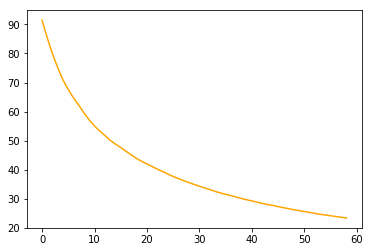

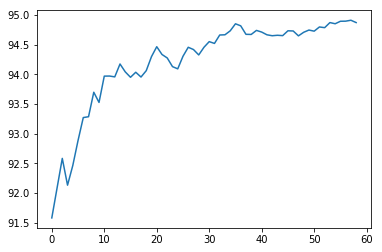

In [163]:
def sigmoid(x):
    return (1 / (1 + numpy.exp(-x)))

num_of_profiles_to_test = num_of_profiles_to_generate

if num_of_profiles_to_test > num_of_profiles_to_generate:
    print("You cannot test that number of profiles")
    exit(1)
    
user_vectors_mat = user_vectors_mat[0:num_of_profiles_to_test,:]
assert user_vectors_mat.shape[0] == num_of_profiles_to_test

# calculate rank_real
rank_real = numpy.matmul(X, numpy.transpose(user_vectors_mat))
creative_ids_vec = numpy.transpose(numpy.array([creative_ids]))  # [num_of_ads X 1]

creatives_rank_real = pd.DataFrame(data=rank_real,    # values
             index=creative_ids_vec[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

#creatives_rank_real = sigmoid(creatives_rank_real)

print("creatives_rank_real:")
print(creatives_rank_real)  # [num_of_ads X num_of_user_vectors]

# calculate rank_low
# remove biases from user_vectors_mat (last two colums are for bias)
#user_vectors_mat_no_bias = user_vectors_mat[:,0:-2]
user_vectors_mat_no_bias = user_vectors_mat[:,0:-1]
# dimentionality reduction on user_vectors_mat_no_bias
user_vectors_mat_no_bias_low = numpy.matmul(user_vectors_mat_no_bias, UX[:, 0:K])  # 210X968 * 968XK

# multiply each low user vector with all the creatives vectors
rank_low = numpy.matmul(X_low[:,0:-1], numpy.transpose(user_vectors_mat_no_bias_low)) + user_vector_bias;  # we use the user_vector_bias from the generated low model
creatives_rank_low = pd.DataFrame(data=rank_low[0:,0:],    # values
             index=creative_ids_vec[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

#creatives_rank_low = sigmoid(creatives_rank_low)

print("creatives_rank_low:")
print(creatives_rank_low)  # [num_of_ads X num_of_user_vectors]

creatives_rank_diff = numpy.abs(creatives_rank_real - creatives_rank_low)
print("creatives_rank_diff:")
print(creatives_rank_diff)  # [num_of_ads X num_of_user_vectors]

print("rank_diff avg [" + str(numpy.mean(numpy.mean(creatives_rank_diff))) + "]")
print("rank_diff std [" + str(numpy.mean(numpy.std(creatives_rank_diff))) + "]")

correct_first_ad = creatives_rank_low.idxmax(axis=0, skipna=True) == creatives_rank_real.idxmax(axis=0, skipna=True)
print("Correct first ad [" + str(((correct_first_ad == 1).sum() * 100) / num_of_profiles_to_test) + "%]")

pct_values = []
creatives_sorted_low = (creatives_rank_low.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True))
creatives_sorted_real = (creatives_rank_real.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True))
correct_ads = creatives_sorted_low == creatives_sorted_real
num_of_ads_in_auction_range = range(1,60)
for num_of_ads_in_auction in num_of_ads_in_auction_range:
    correct_ads_sliced = correct_ads.iloc[-num_of_ads_in_auction:,:]  # by default argsort is ascending
    pct_values.append(((correct_ads_sliced == 1).sum().sum() * 100) / (correct_ads_sliced.shape[0] * correct_ads_sliced.shape[1]))
    
gg = pd.DataFrame.from_dict({
    'num_of_ads_in_auction': num_of_ads_in_auction_range,
    'correct_ads_pct': pct_values
})

plt.figure(1)
plt.plot(gg['correct_ads_pct'], color='orange')

pct_values = []
for num_of_ads_in_auction in num_of_ads_in_auction_range:
    count = 0
    for user_idx in range(0,num_of_profiles_to_test - 1):
        count += (creatives_sorted_low.iloc[-num_of_ads_in_auction:,user_idx].isin(creatives_sorted_real.iloc[-num_of_ads_in_auction:,user_idx]) == 1).sum().sum()
    pct_values.append((count * 100) / (num_of_ads_in_auction * (user_idx + 1)))
    
df = pd.DataFrame.from_dict({
    'num_of_ads_in_auction': num_of_ads_in_auction_range,
    'ads_contained_pct': pct_values
})

plt.figure(2)
plt.plot(df['ads_contained_pct'])

214354    True
214355    True
214356    True
214357    True
214358    True
214359    True
214360    True
214361    True
214362    True
214363    True
214364    True
214365    True
214366    True
214367    True
214368    True
214369    True
214370    True
Name: 10, dtype: bool


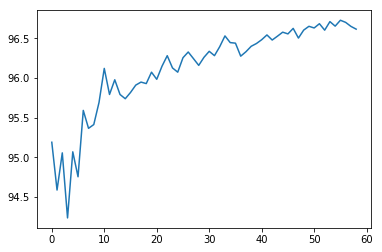

In [144]:
print(creatives_sorted_low.iloc[-17:,10].isin(creatives_sorted_real.iloc[-17:,10]))
plt.plot(df['ads_contained_pct'])

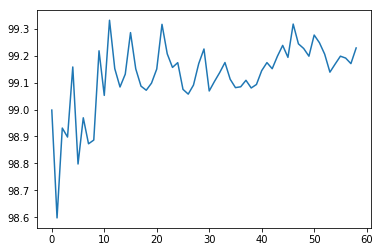

In [113]:
pct_values = []
for num_of_ads_in_auction in num_of_ads_in_auction_range:
    count = 0
    for user_idx in range(0,num_of_profiles_to_test - 1):
        count += (creatives_sorted_low.iloc[-num_of_ads_in_auction:,user_idx].isin(creatives_sorted_real.iloc[-num_of_ads_in_auction:,user_idx]) == 1).sum().sum()
    pct_values.append((count * 100) / (num_of_ads_in_auction * (user_idx + 1)))
    
df = pd.DataFrame.from_dict({
    'num_of_ads_in_auction': num_of_ads_in_auction_range,
    'ads_contained_pct': pct_values
})

plt.plot(df['ads_contained_pct'])

In [87]:
print(creatives_sorted_low.iloc[-17:,0])

print(creatives_sorted_real.iloc[-17:,0])

214354    34357333027
214355    34833542374
214356    34839426890
214357    34285263367
214358    32644220597
214359    34803242763
214360    34844361359
214361    34788612785
214362    34468058092
214363    34128749857
214364    34822227583
214365    34810165598
214366    34803238342
214367    34830658055
214368    34822227582
214369    34451232222
214370    34822227578
Name: 0, dtype: object
214354    34778448751
214355    34833542374
214356    34839426890
214357    34285263367
214358    32644220597
214359    34803242763
214360    34844361359
214361    34788612785
214362    34468058092
214363    34128749857
214364    34822227583
214365    34810165598
214366    34803238342
214367    34830658055
214368    34822227582
214369    34451232222
214370    34822227578
Name: 0, dtype: object


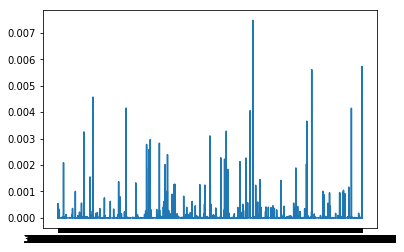

In [22]:
plt.plot(creatives_rank_diff.iloc[:100,0])

In [24]:
creatives_rank_low.idxmax(axis=0, skipna=True)

0      34186877847
1      34501790886
2      34326707097
3      34283412639
4      34231405421
5      34503095909
6      34087531258
7      34453797063
8      34499670810
9      33562623303
10     34510215785
11     34116853071
12     34503687182
13     34481370615
14     34454446337
15     34481383562
16     34502314156
17     34378031255
18     34118098276
19     34033628462
20     34458369420
21     34215413507
22     34384353424
23     34384363353
24     34391869199
25     34434283384
26     34231405421
27     34503687185
28     32636200279
29     34371788677
          ...     
470    34378036368
471    34488406047
472    34501353407
473    33721103440
474    34461734350
475    34475029915
476    34502474438
477    34371788756
478    34371788674
479    34384353424
480    34484800056
481    34475356428
482    33562623303
483    34481998056
484    34394684399
485    34501790886
486    34371788674
487    34434283384
488    34287962015
489    34476412045
490    34287962015
491    34484

In [25]:
creatives_rank_low.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,34490327437,34384709875,34384709875,34384709875,34384709875,34490327437,34453844328,34232463056,34453797061,34384709875,...,34462028287,34384709875,34384709875,34490343887,34488042900,34489105814,34453844328,34239996317,34231941391,32717335112
1,34490338808,34384709874,34384709874,34384709874,34384709874,34490343887,34492867211,34239996317,34453797063,34384709874,...,34150182211,34384709874,34384709874,34490327437,34384709875,34488759253,34499406088,34231941391,34239996317,32516545713
2,34490343887,34453844328,34490338808,34453844328,34490350292,34490338808,34437992348,34231941391,34453797059,34490327437,...,34250998922,34489105814,34492867211,34490338808,34384709874,34489750038,34501767600,34232463056,34232463056,33609371729
3,34490350292,34488042900,34490343887,33629418944,34490338808,34490325330,34437992349,34490343887,34503248542,34490338808,...,33175053744,34489750038,34453844328,34490350292,34492867211,34499068859,34502303356,34481413756,32780568283,34033628462
4,34490338934,34502972261,34490350292,34453829845,34490327437,34490338934,34285293688,34490338808,34501622015,34490350292,...,34499485427,34488759253,34488042900,34490338934,34497400813,34499244084,34384709875,34490350292,34503082528,34030804494
5,34490341448,34502974157,34490327437,34122550310,34490338934,34490350292,34499485427,34490338934,34501353407,34490343887,...,34458371472,34499244084,34329408158,34490341448,34418966311,34499244083,34384709874,34490338934,34502474438,33655006466
6,34490325330,34488821456,34490338934,34122550308,34490343887,34490341448,34499406088,34490327437,34503207406,34490338934,...,34490439340,34499068859,34499406088,34490325330,34453844328,34490327437,34453829845,34490342290,32516554445,31830874738
7,34490318947,34502314156,34490318947,34488042900,34490341448,34490347476,34501767600,34490341448,34503190845,34490325330,...,34219760404,34490327437,34502972261,34490318947,34387580069,34490343887,34499485427,34490327437,34116037272,33668052988
8,34490342290,34488723744,34490341448,34122528626,34490318947,34490318947,34180221591,34490350292,34503244082,34490341448,...,34333075127,34499244083,34374299365,34490342290,34437992348,34490338808,34503342731,34490343887,34504405953,32520145935
9,34490347476,34488723743,34490325330,34487957061,34490325330,34490342290,34453829845,34490325330,34488759253,34490318947,...,32611729452,34490338808,34502974157,34490318723,34387581103,34490341448,34490327437,34490341448,34504405963,34067294287


In [40]:
aa = correct_ads.iloc[-1:,:]
print(aa)
print((aa==1).sum().sum())
((aa==1).sum().sum() * 100) / (aa.shape[0] * aa.shape[1])

         0     1     2     3     4     5     6     7     8     9    ...   490  \
260041  True  True  True  True  True  True  True  True  True  True  ...  True   

         491   492   493   494   495   496   497   498   499  
260041  True  True  True  True  True  True  True  True  True  

[1 rows x 500 columns]
394


78.8